In [1]:
import os
import sys
import xarray as xr
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
def write_histogram_regions(precip, mcsmask, tb, bins_precip, geo_info, mask_type='all'):
    """
    write out histogram of BL values by the given bins
    """
    samples = np.zeros(len(bins_precip)-1)
   
    precip_sub = precip.sel(lat=slice(geo_info[0],geo_info[1])
                                , lon=slice(geo_info[2],geo_info[3]))
    mcsmask_sub = mcsmask.sel(lat=slice(geo_info[0],geo_info[1])
                                , lon=slice(geo_info[2],geo_info[3]))
    tb_sub = tb.sel(lat=slice(geo_info[0],geo_info[1])
                                , lon=slice(geo_info[2],geo_info[3]))
    if mask_type == 'mcs':
        precip_sub = precip_sub.where(mcsmask_sub > 0)
    if mask_type == 'nonmcs_deep':
        precip_sub = precip_sub.where((mcsmask_sub == 0) & (tb_sub < 241)) 
    if mask_type == 'nonmcs_rest':
        precip_sub = precip_sub.where((mcsmask_sub == 0) & (tb_sub > 241))        

    # get 1-D BL values over the specified region
    precip_1d = np.reshape(precip_sub.values, (len(precip_sub.lat)*len(precip_sub.lon)))

    for n in range(len(bins_precip)-1):
        idx = np.where(np.logical_and(precip_1d >= bins_precip[n], precip_1d < bins_precip[n+1]))[0]
        samples[n] = len(idx)
    
    return (samples)

In [25]:
%%time
# defined tropical regions
WPC = [-10,10,110,140]
IND = [-10,5,70,90]
EPC = [0,10,240,260]
ATL = [0,10,320,340]
WAF = [-10,10,0,30]
MC  = [-7,7,95,125]
AMZ = [-10,5,285,310]

#BL_dir = Path('/neelin2020/ERA-5_buoy/layer_thetae')
#data_temp = xr.open_dataset(BL_dir / 'era5_2layers_thetae_2008_06_19.nc').sel(lat=slice(-30,30))
lon_re = np.arange(0,360,0.25)
lat_re = np.arange(-30,30.25,0.25)

# processing data writeout
bins_precip = np.arange(0,120,1) # degree Kelvin
samples = np.zeros((3,7,len(bins_precip)-1)) # gridtype, bins

year = 2012
print('processing year: {}'.format(year))
mcs_dir = Path('/neelin2020/mcs_flextrkr/{}/'.format(year))
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/buoy_precip_1D_multiregions')

for month in np.arange(1,13):
    print('month: {}'.format(str(month).zfill(2)))

    ##########
    mcsfiles = list(mcs_dir.glob('mcstrack_{}{}*_0030.nc'.format(year,str(month).zfill(2)))) + \
               list(mcs_dir.glob('mcstrack_{}{}*_0630.nc'.format(year,str(month).zfill(2)))) + \
               list(mcs_dir.glob('mcstrack_{}{}*_1230.nc'.format(year,str(month).zfill(2)))) + \
               list(mcs_dir.glob('mcstrack_{}{}*_1830.nc'.format(year,str(month).zfill(2)))) 
    mcsfiles = sorted(mcsfiles)
    data_mcs = xr.open_mfdataset(mcsfiles).sel(lat=slice(-30,30))
    # reconstruct time info of dataset
    date_list = []
    for tt in data_mcs.time.values:
        timestamp = str(tt)
        year = int(timestamp[:4])
        month = int(timestamp[5:7])
        day = int(timestamp[8:10])
        hour = int(timestamp[11:13])
        date_list.append(datetime(year,month,day,hour))
    data_mcs['time'] = date_list
    precip = (data_mcs.precipitation)#.interp(lat=lat_re, lon=lon_re)
    mcsmask = (data_mcs.cloudtracknumber_nomergesplit.fillna(0))#.interp(lat=lat_re, lon=lon_re)
    tb = (data_mcs.tb)#.interp(lat=lat_re, lon=lon_re)
    ##########

    for t in precip.time:
        for n, geo_info in enumerate([WPC, IND, EPC, ATL, WAF, MC, AMZ]):
            (b_samples) = write_histogram_regions(precip.sel(time=t), 
                                                  mcsmask.sel(time=t),
                                                  tb.sel(time=t),
                                                  bins_precip, geo_info, mask_type='mcs')
            samples[0,n] += b_samples

            (b_samples) = write_histogram_regions(precip.sel(time=t), 
                                                  mcsmask.sel(time=t),
                                                  tb.sel(time=t),
                                                  bins_precip, geo_info, mask_type='nonmcs_deep')
            samples[1,n] += b_samples

            (b_samples) = write_histogram_regions(precip.sel(time=t), 
                                                  mcsmask.sel(time=t),
                                                  tb.sel(time=t),
                                                  bins_precip, geo_info, mask_type='nonmcs_rest')
            samples[2,n] += b_samples

# writeout data
ds = xr.Dataset(data_vars = dict(samples = (['grid_type','region','precip_bins'], samples)),
                coords = dict(grid_type = (['grid_type'], ['mcs','nonmcs_deep','nonmcs_rest']),
                              BL_bins = (['precip_bins'], bins_precip[:-1]),
                              region = (['region'], ['WPC','IND','EPC','ATL','WAF','MC','AMZ'])),
                attrs = dict(description = 'precip histogram in tropical regions',
                             unit = '(mm/hr)')
                ) 
ds.to_netcdf(out_dir / 'preciphist_1D_multiregions.{}.gridtype.nc'.format(year))

processing year: 2012
month: 01
month: 02
month: 03
month: 04
month: 05


KeyboardInterrupt: 

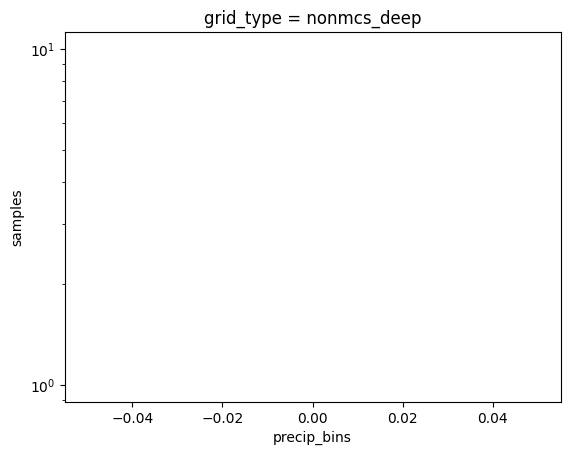

In [21]:
#(ds.samples.sel(grid_type='mcs').sum(['region'])/ds.samples.sel(grid_type='mcs').sum(['region']).sum('precip_bins')).plot(color='k')
(ds.samples.sel(grid_type='nonmcs_deep').sum(['region'])/ds.samples.sel(grid_type='nonmcs_deep').sum(['region']).sum('precip_bins')).plot(color='k')
#(ds.samples.sel(grid_type='nonmcs_rest').sum(['region'])/ds.samples.sel(grid_type='nonmcs_rest').sum(['region']).sum('precip_bins')).plot(color='k')
plt.yscale('log')

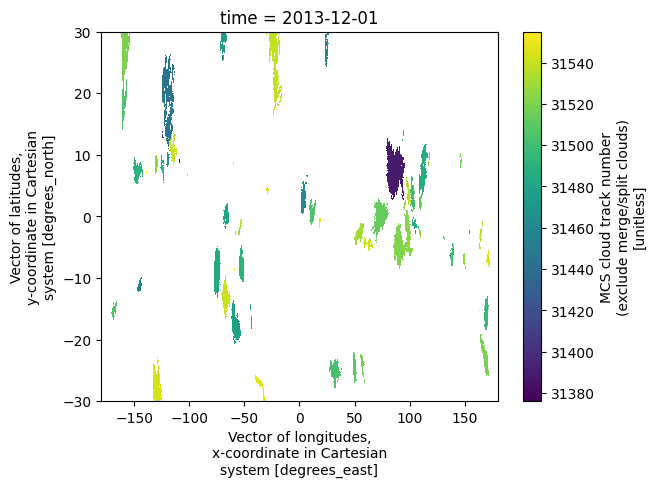

In [24]:
mcsmask.isel(time=0).sel(lat=slice(-30,30)).plot()